20661
債
Lowest ratio corner: 0.26262626262626265
Highest ratio corner: 1.0303030303030303


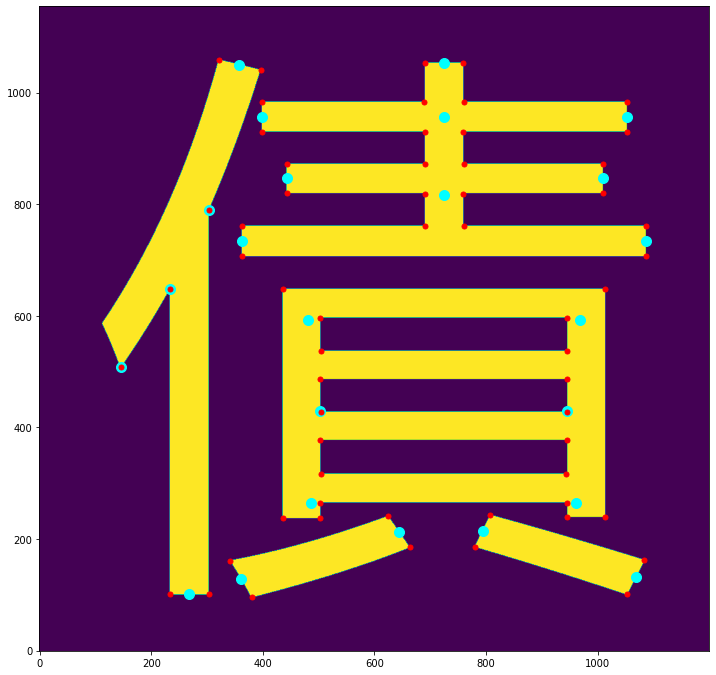

In [1]:
import Strokes as st
import HandImage as wi
import FormalImage as fi

from Anchors import AnchorConverter

import numpy as np
import matplotlib.pyplot as plt

character = chr(ord('\u4E00') +  np.random.randint(10000))
print(ord(character))
print(character)

charImg = fi.renderChar(character, show=False, fontsize=1000)

#create object and get anchors from the img
anchorConv = AnchorConverter()
anchorConv.diffThresh=.26
anchors, corners = anchorConv.get(charImg, getCorners=True)

#plot img and anchors over each other
fig, ax = plt.subplots(figsize=(12,12))
#ax.invert_yaxis()
plt.imshow(charImg)
ax.plot(anchors[:,1], anchors[:,0], ".", color="cyan", ms=20)
ax.plot(corners[:,1], corners[:,0], ".", color="red", ms=10)
plt.gca().invert_yaxis()

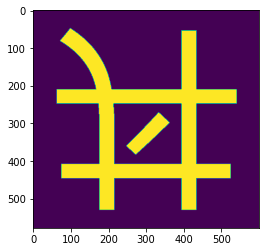

In [25]:
import Strokes as st
import HandImage as wi
import FormalImage as fi
import numpy as np
import matplotlib.pyplot as plt

character = '\u4e3c'

charImg = fi.renderChar(character, show=True, fontsize=500)
plt.imshow(charImg)

(1157, 1200)
0.6039215686274509


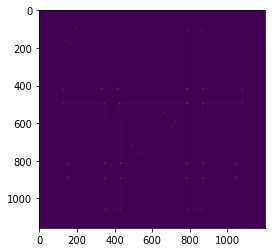

In [111]:
#go through each pixel and count it's white and black neighbors, then each cell value is abs(blackCount - whiteCount)
diffImg = np.zeros(np.shape(charImg))
imgColor = charImg.copy() #black is set to 1 already
imgColor[charImg == 0] = -1 #set white pixels to -1

print(np.shape(diffImg))

borderDiff = 8 #e.g. check up to borderDiff away from center, recommended value is 10
pad = 1 #ignore the border for this thickness
totalPad = borderDiff+pad
for xDiff in range(-borderDiff,1+borderDiff):
    for yDiff in range(-borderDiff,1+borderDiff):
        if(xDiff == 0 and yDiff == 0): #we don't count the center
            continue
        diffImg[totalPad:-totalPad, totalPad:-totalPad] += imgColor[totalPad+yDiff:-totalPad+yDiff, totalPad+xDiff:-totalPad+xDiff]
diffImg = np.abs(diffImg)

#now determine which pixels are on the border (black but touches a white pixel, corner doesn't count)
borderImg = np.zeros(np.shape(charImg)) #zero is not a border
borderImg[1:-1, 1:-1][(charImg[1:-1, 1:-1] == 1) & (charImg[:-2, 1:-1] == 0)] = 1 #up direction
borderImg[1:-1, 1:-1][(charImg[1:-1, 1:-1] == 1) & (charImg[2:, 1:-1] == 0)] = 1 #down direction
borderImg[1:-1, 1:-1][(charImg[1:-1, 1:-1] == 1) & (charImg[1:-1, :-2] == 0)] = 1 #left direction
borderImg[1:-1, 1:-1][(charImg[1:-1, 1:-1] == 1) & (charImg[1:-1, 2:] == 0)] = 1 #right direction

#reset any pixels that aren't a border
diffImg[borderImg != 1] = 0
diffImg /= (borderDiff*2)**2 - 1 #ratio of total pixels counted

print(np.max(diffImg))
plt.imshow(diffImg)

plt.imsave("testImg.png", diffImg)

0.3843137254901961
0.6039215686274509


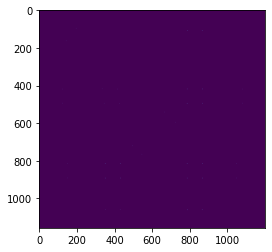

In [112]:
#now we have high values marked in each "corner", we need to select one pixel per corner
#select only global maximums
maxImg = np.zeros(np.shape(diffImg))
maxImg[diffImg > .25] = 1 #anything above a 25% difference is a canidate for being a corner

#check each neighboring pixel, and if it is higher, set the center pixel to zero

pad = 1
borderDiff = 5 #e.g. check up to borderDiff away from center for higher value, recommended value is 5
totalPad = borderDiff+pad
centerMask = diffImg[totalPad:-totalPad, totalPad:-totalPad]
for xDiff in range(-borderDiff,1+borderDiff):
    for yDiff in range(-borderDiff,1+borderDiff):
        if(xDiff == 0 and yDiff == 0): #we don't count the center
            continue
        offsetMask = diffImg[totalPad+yDiff:-totalPad+yDiff, totalPad+xDiff:-totalPad+xDiff]
        maxImg[totalPad:-totalPad, totalPad:-totalPad][ centerMask < offsetMask ] = 0 #neighbor is higher value
maxImg[maxImg != 0] = 1 #1's are where corners are located

print("Lowest ratio corner:", min(diffImg[maxImg == 1])) #lowest diff that passed the test
print(max(diffImg[maxImg == 1])) #highest diff that passed the test

plt.imshow(maxImg)
plt.imsave("testImg2.png", maxImg)

In [125]:
print(np.sort(diffImg[maxImg == 1]))

[0.38431373 0.43921569 0.43921569 0.43921569 0.43921569 0.45490196
 0.47843137 0.48627451 0.50196078 0.50196078 0.50196078 0.50196078
 0.50196078 0.50196078 0.50196078 0.50196078 0.50196078 0.50196078
 0.51764706 0.54117647 0.54117647 0.54901961 0.56470588 0.56470588
 0.56470588 0.56470588 0.56470588 0.56470588 0.56470588 0.56470588
 0.56470588 0.56470588 0.56470588 0.56470588 0.60392157 0.60392157]


In [113]:
#almost there now we need to remove ties, simplest way is just to give precedence to certain pixels
borderDiff = 5 #remove a tie if a pixel is found this close to another
for y in range(len(maxImg)):
    for x in range(len(maxImg[0])):
        if(maxImg[y,x] == 1):
            maxImg[y-borderDiff:y+borderDiff, x-borderDiff:x+borderDiff] = 0 #set all nearby to 0
            maxImg[y,x] = 1 #reset the center back to 1

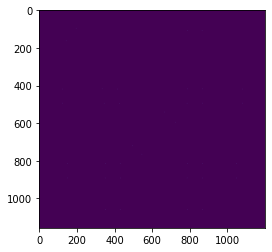

In [114]:
plt.imshow(maxImg)
plt.imsave("testImg2.png", maxImg)

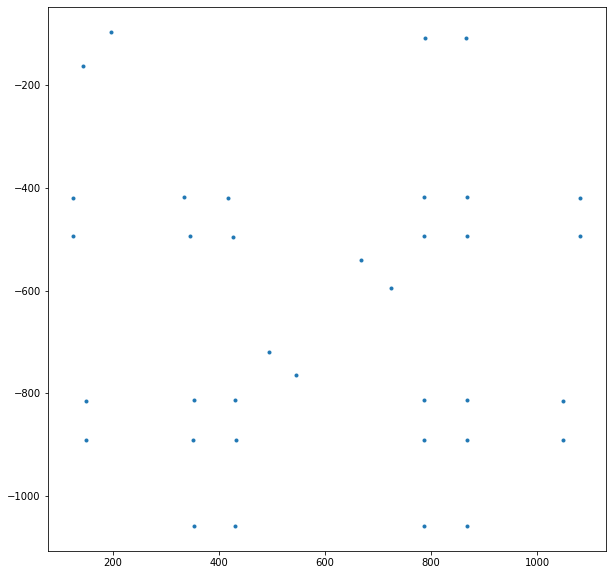

In [115]:
corners = np.array(np.column_stack(np.where(maxImg == 1)))

fig, ax = plt.subplots(figsize=(10,10))
ax.plot(corners[:,1], -corners[:,0], ".")

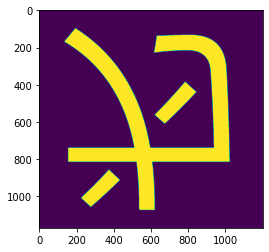

In [30]:
plt.imshow(charImg)

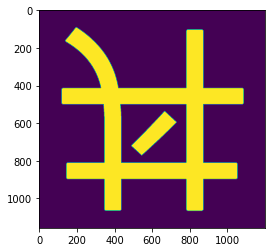

In [116]:
#we're going to grow the image a couple pixels so we can see which corners relate to the same anchor point.

charGrow = charImg.copy()
charGrow[charImg == 1] = 0 #make black zero
charGrow[charImg == 0] = 1 #make white one (this is used for multiplying)

pixelGrow = 5 #how many pixels to grow note that corners don't count
for i in range(pixelGrow):
    nextIter = charGrow.copy()
    #multiply neighbors so any single black will make the pixel black and it can't be undone
    nextIter[1:-1, 1:-1] *= charGrow[:-2, 1:-1] #left
    nextIter[1:-1, 1:-1] *= charGrow[2:, 1:-1] #right
    nextIter[1:-1, 1:-1] *= charGrow[1:-1, :-2] #up
    nextIter[1:-1, 1:-1] *= charGrow[1:-1, 2:] #down
    
    charGrow = nextIter.copy()
    
#now revert so black is 1, and white is zero
charImgGrow = charGrow.copy()
charImgGrow[charGrow == 1] = 0 #make white zero
charImgGrow[charGrow == 0] = 1 #make black one

plt.imshow(charImgGrow)

## Bruh
constraints for corners belonging to the same anchor point:
Must be a certain distance away (< 10% of the image in each axis)
Path along the corners must be black (just sample about 10 points in between

In [117]:
corners = np.array(np.column_stack(np.where(maxImg == 1)))

shape = np.shape(maxImg)
groups = [] #list of groups in which each group is the list of corners belonging to that anchor point
sampleNum = 5

closePercent = .1
closeness = np.array(shape)*closePercent
matches = False
for corner in corners: #go through each corner and add to existing group or add to new one
    for group in groups:
        #check if corner belongs to the group
        matches = True #assume in the group until proven otherwise
        
        for item in group:
            if( np.any( np.abs(corner - item) > closeness )): #odd way to do this, essentially checks if pixels are too far away
                matches = False
                continue
            samples = np.zeros((sampleNum, 2), dtype=int)
            samples[:,0] = np.linspace(corner[0], item[0], sampleNum, dtype=int)
            samples[:,1] = np.linspace(corner[1], item[1], sampleNum, dtype=int)
            sampleMatch = True
            for sample in samples:
                if(charImgGrow[sample[0], sample[1]] != 1): #this sample fails
                    sampleMatch = False
                    break
            if(not sampleMatch):
                matches = False
                break
        if(matches): #corner belongs to this group
            group.append(corner)
            break
    if(not matches): #needs a new group
        groups.append([corner])
        
print(groups)

[[array([ 96, 197], dtype=int64), array([163, 144], dtype=int64)], [array([108, 788], dtype=int64), array([108, 866], dtype=int64)], [array([418, 335], dtype=int64), array([419, 417], dtype=int64), array([494, 346], dtype=int64), array([495, 426], dtype=int64)], [array([418, 787], dtype=int64), array([418, 867], dtype=int64), array([494, 786], dtype=int64), array([494, 868], dtype=int64)], [array([419, 125], dtype=int64), array([494, 125], dtype=int64)], [array([ 419, 1081], dtype=int64), array([ 494, 1081], dtype=int64)], [array([541, 667], dtype=int64), array([595, 725], dtype=int64)], [array([720, 495], dtype=int64), array([765, 546], dtype=int64)], [array([814, 352], dtype=int64), array([814, 431], dtype=int64), array([891, 351], dtype=int64), array([891, 432], dtype=int64)], [array([814, 787], dtype=int64), array([814, 867], dtype=int64), array([891, 786], dtype=int64), array([891, 868], dtype=int64)], [array([815, 150], dtype=int64), array([891, 150], dtype=int64)], [array([ 815,

[[ 129  170]
 [ 108  827]
 [ 456  381]
 [ 456  827]
 [ 456  125]
 [ 456 1081]
 [ 568  696]
 [ 742  520]
 [ 852  391]
 [ 852  827]
 [ 853  150]
 [ 853 1048]
 [1059  391]
 [1059  827]]


(0.0, 1200.0)

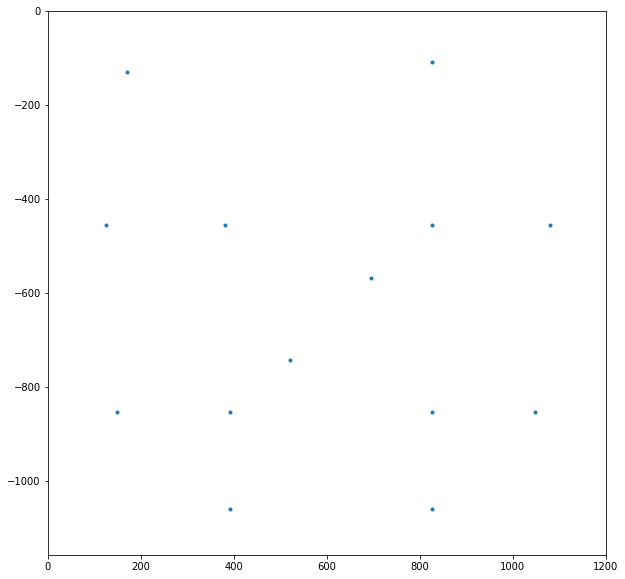

In [121]:
anchorPoints = []
for group in groups:
    anchorPoints.append(np.mean(group, axis=0, dtype=int))
anchorPoints = np.array(anchorPoints)

print(anchorPoints)

fig, ax = plt.subplots(figsize=(10,10))
ax.plot(anchorPoints[:,1], -anchorPoints[:,0], ".")
ax.set_ylim(-shape[0], 0)
ax.set_xlim(0,shape[1])

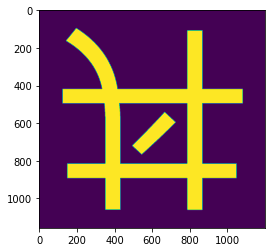

In [119]:
plt.imshow(charImg)

In [138]:
class bruh:
    def __init__(self):
        print("hi")
        self._v = 1
        self.__v = -1
        self.__func1()
    def func1(self):
        print("hi public")
        print(self._v)
    def __func1(self):
        print("hi private")
        print(self.__v2)
        
b = bruh()
print(b.func1())
print(b.__v)


hi
hi private


AttributeError: 'bruh' object has no attribute '_bruh__v2'